### Contrastive Loss
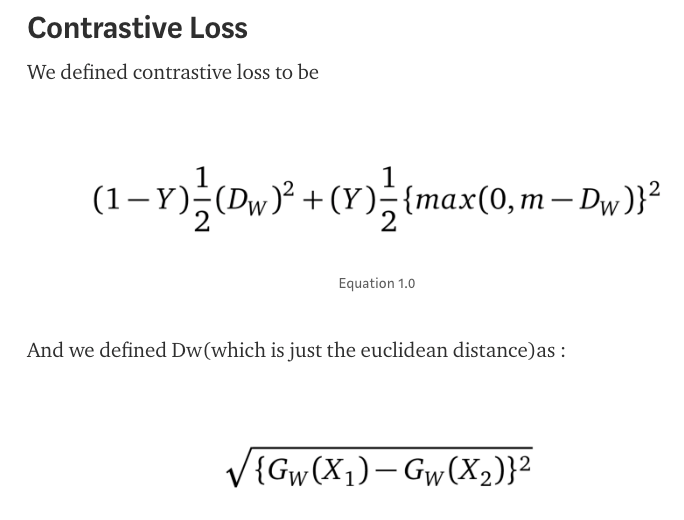

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [3]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        output1, output2 = output
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [4]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 10

In [5]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, root):
        self.class_dict = {}
        self.image_folder = datasets.ImageFolder(root)
        transform = transforms.Compose([
                        transforms.Resize((100,100)),
                        transforms.ToTensor()
                    ])
        self.all_images = []
        
        # 1. separate paths by index, open image, and transform
        for path, class_index in self.image_folder.imgs:
            if class_index not in self.class_dict:
                self.class_dict[class_index] = []
            image = transform(
                        Image.open(path).convert('L') # L is grayscale mode
                    )
            self.class_dict[class_index].append(image)
            self.all_images.append((image, class_index))
            
        # 2. prepare dict of other indexes that are not current index (for random)
        indexes = [self.image_folder.class_to_idx[class_name]
                   for class_name in self.image_folder.classes]
        self.not_index = {}
        for index in indexes:
            new_indexes = indexes[:]
            new_indexes.remove(index)
            self.not_index[index] = new_indexes
        
    def get_images_by_class_index(self, class_index):
        return self.class_dict[class_index]
    
    def __getitem__(self, index):
        image_0, class_index_0 = random.choice(self.all_images)
        is_same_class = random.randint(0, 1)
        if is_same_class:
            class_index_1 = class_index_0
        else:
            # to make sure getting images from same class 50%
            class_index_1 = random.choice(self.not_index[class_index_0])
        image_1 = random.choice(self.get_images_by_class_index(class_index_1))
        
        return image_0, image_1, torch.tensor(is_same_class, dtype=torch.float32)
    def __len__(self):
        return len(self.image_folder.imgs)

### Train

In [6]:
from exitai.learner import Learner
train_dataset = SiameseNetworkDataset(root=Config.training_dir)
test_dataset = SiameseNetworkDataset(root=Config.testing_dir)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, num_workers=8, batch_size=512)

net = SiameseNetwork()
criterion = ContrastiveLoss()
learner = Learner(train_dataloader, test_dataloader, net, criterion)

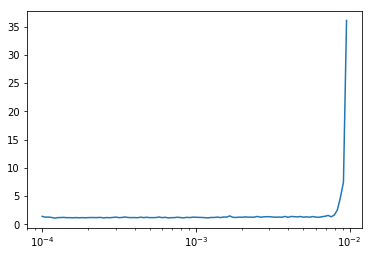

In [7]:
learner.lr_find(start_lr=1e-4, end_lr=0.01, num_it=100)

In [8]:
def eval_func(loss, output, target):
    output1, output2 = output
    euclidean_distance = F.pairwise_distance(output1, output2)
    return 0
learner = Learner(train_dataloader, test_dataloader, net, criterion)
learner.fit(0.0005, num_epochs=100, cycle=None, eval_func=eval_func)

---- epoch:0 ------
   [train] Average loss: 3.4311, acc: 0.00%
   [test] Average loss: 8.0000, acc: 0.00%
---- epoch:1 ------
   [train] Average loss: 3.1926, acc: 0.00%
   [test] Average loss: 4.4444, acc: 0.00%
---- epoch:2 ------
   [train] Average loss: 3.4020, acc: 0.00%
   [test] Average loss: 4.8889, acc: 0.00%
---- epoch:3 ------
   [train] Average loss: 3.3446, acc: 0.00%
   [test] Average loss: 4.8889, acc: 0.00%
---- epoch:4 ------
   [train] Average loss: 3.5061, acc: 0.00%
   [test] Average loss: 5.3333, acc: 0.00%
---- epoch:5 ------
   [train] Average loss: 2.9926, acc: 0.00%
   [test] Average loss: 8.0000, acc: 0.00%
---- epoch:6 ------
   [train] Average loss: 3.0554, acc: 0.00%
   [test] Average loss: 8.8889, acc: 0.00%
---- epoch:7 ------
   [train] Average loss: 3.3061, acc: 0.00%
   [test] Average loss: 6.6667, acc: 0.00%
---- epoch:8 ------
   [train] Average loss: 3.2290, acc: 0.00%
   [test] Average loss: 8.4444, acc: 0.00%
---- epoch:9 ------
   [train] Averag

In [9]:
for i in range(100):
    threshold = i/100
    print('threshold:',threshold)
    def eval_func(loss, output, target):
        output1, output2 = output
        euclidean_distance = F.pairwise_distance(output1, output2)
        predict = (euclidean_distance > threshold).float()
        return predict.eq(target.squeeze()).sum().item()
    learner.predict(eval_func)

threshold: 0.0
   [test] Average loss: 7.1111, acc: 53.33%
threshold: 0.01
   [test] Average loss: 7.1111, acc: 46.67%
threshold: 0.02
   [test] Average loss: 7.5555, acc: 43.33%
threshold: 0.03
   [test] Average loss: 6.2222, acc: 53.33%
threshold: 0.04
   [test] Average loss: 6.6667, acc: 50.00%
threshold: 0.05
   [test] Average loss: 8.0000, acc: 40.00%
threshold: 0.06
   [test] Average loss: 6.2222, acc: 53.33%
threshold: 0.07
   [test] Average loss: 7.5555, acc: 43.33%
threshold: 0.08
   [test] Average loss: 7.1111, acc: 46.67%
threshold: 0.09
   [test] Average loss: 8.0000, acc: 40.00%
threshold: 0.1
   [test] Average loss: 4.0000, acc: 70.00%
threshold: 0.11
   [test] Average loss: 6.2222, acc: 53.33%
threshold: 0.12
   [test] Average loss: 6.6667, acc: 50.00%
threshold: 0.13
   [test] Average loss: 6.6667, acc: 50.00%
threshold: 0.14
   [test] Average loss: 7.1111, acc: 46.67%
threshold: 0.15
   [test] Average loss: 9.3333, acc: 30.00%
threshold: 0.16
   [test] Average loss: 5.

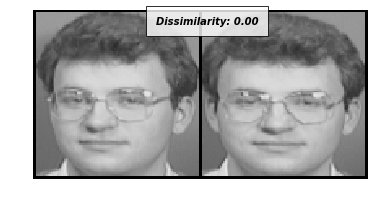

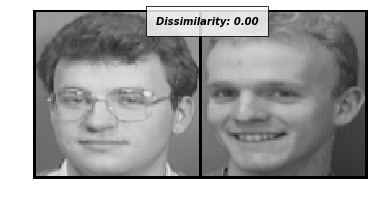

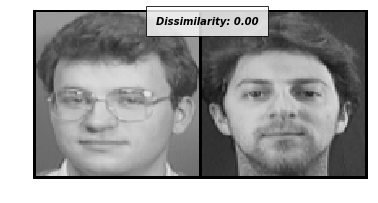

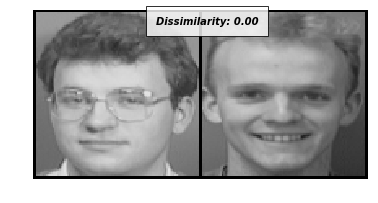

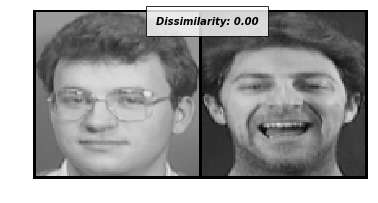

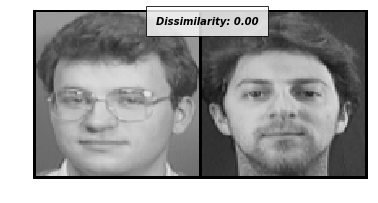

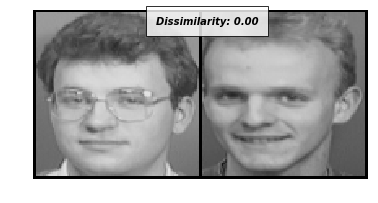

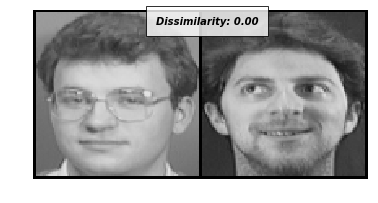

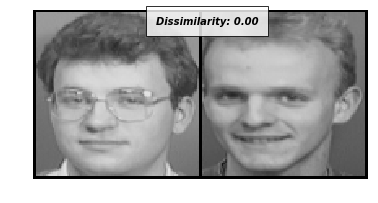

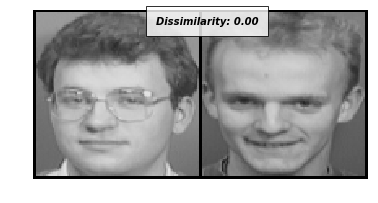

In [10]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() 
folder_dataset_test = datasets.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(Config.testing_dir)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

for i in range(10):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))